# Set-up

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Import Data

In [2]:
try:
    train_df = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv')
    test_df = pd.read_csv('/kaggle/input/fraud-detection/fraudTest.csv')
except:
    train_df = pd.read_csv('fraudTrain.csv')
    test_df = pd.read_csv('fraudTest.csv')

In [3]:
train_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


### Data imbalance check

In [4]:
fig = px.pie(values=train_df['is_fraud'].value_counts(), names=["Genuine","Fraud"] , width=700, height=400, color_discrete_sequence=["skyblue","black"]
             ,title="Fraud vs Genuine transactions")
fig.show()

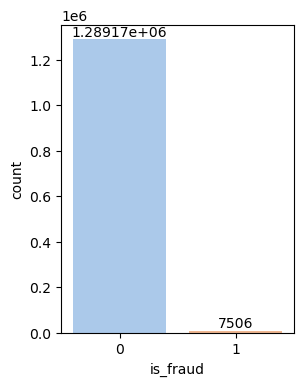

In [5]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='is_fraud',data=train_df,palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)

In [6]:
print('Genuine:', round(train_df['is_fraud'].value_counts()[0]/len(train_df) * 100,2), '% of the dataset')
print('Frauds:', round(train_df['is_fraud'].value_counts()[1]/len(train_df) * 100,2), '% of the dataset')

Genuine: 99.42 % of the dataset
Frauds: 0.58 % of the dataset


In this dataset:

we have 99.42% of Genuine transactions and only 0,58% (7506) of fraud transactions; which means that a blind guess (bet on Genuine) would give us accuracy of 99.42%.

# Data cleaning

In [7]:
train_df.info(),test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

(None, None)

In [8]:
train_df.isnull().sum(),test_df.isnull().sum()

(Unnamed: 0               0
 trans_date_trans_time    0
 cc_num                   0
 merchant                 0
 category                 0
 amt                      0
 first                    0
 last                     0
 gender                   0
 street                   0
 city                     0
 state                    0
 zip                      0
 lat                      0
 long                     0
 city_pop                 0
 job                      0
 dob                      0
 trans_num                0
 unix_time                0
 merch_lat                0
 merch_long               0
 is_fraud                 0
 dtype: int64,
 Unnamed: 0               0
 trans_date_trans_time    0
 cc_num                   0
 merchant                 0
 category                 0
 amt                      0
 first                    0
 last                     0
 gender                   0
 street                   0
 city                     0
 state                    0
 zip 

### 1. Drop Columns

In [9]:
#Drop Columns that are not relevant to predicy fraud transaction
drop_columns = ['Unnamed: 0','cc_num','merchant','trans_num','unix_time','first','last','street','zip']
train_df.drop(columns=drop_columns,inplace=True)
test_df.drop(columns=drop_columns,inplace=True)

In [10]:
print(train_df.shape)
print(test_df.shape)

(1296675, 14)
(555719, 14)


### 2. Handle Date time

In [11]:
train_df['trans_date_trans_time']=pd.to_datetime(train_df['trans_date_trans_time'])
train_df['trans_date']=train_df['trans_date_trans_time'].dt.strftime('%Y-%m-%d')
train_df['trans_date']=pd.to_datetime(train_df['trans_date'])
train_df['dob']=pd.to_datetime(train_df['dob'])

test_df['trans_date_trans_time']=pd.to_datetime(test_df['trans_date_trans_time'])
test_df['trans_date']=test_df['trans_date_trans_time'].dt.strftime('%Y-%m-%d')
test_df['trans_date']=pd.to_datetime(test_df['trans_date'])
test_df['dob']=pd.to_datetime(test_df['dob'])

# Data Preprocessing

### 1. Feature Engineering

In [12]:
#Calculate Age
train_df["age"] = train_df["trans_date"]-train_df["dob"]
train_df["age"]=train_df["age"].astype('timedelta64[Y]')

test_df["age"] = test_df["trans_date"]-test_df["dob"]
test_df["age"]=test_df["age"].astype('timedelta64[Y]')

In [13]:
# Get Transaction Month & Year
train_df['trans_month'] = pd.DatetimeIndex(train_df['trans_date']).month
train_df['trans_year'] = pd.DatetimeIndex(train_df['trans_date']).year

In [14]:
#Calculate distance between merchant and home location
train_df['latitudinal_distance'] = abs(round(train_df['merch_lat']-train_df['lat'],3))
train_df['longitudinal_distance'] = abs(round(train_df['merch_long']-train_df['long'],3))

test_df['latitudinal_distance'] = abs(round(test_df['merch_lat']-test_df['lat'],3))
test_df['longitudinal_distance'] = abs(round(test_df['merch_long']-test_df['long'],3))

In [15]:
#Drop Columns that are not relevant to predicy fraud transaction
drop_columns = ['trans_date_trans_time','city','lat','long','job','dob','merch_lat','merch_long','trans_date','state']
train_df.drop(columns=drop_columns,inplace=True)
test_df.drop(columns=drop_columns,inplace=True)

In [17]:
# Convert categorical column gender into numerical 
train_df.gender=train_df.gender.apply(lambda x: 1 if x=="M" else 0)
test_df.gender=test_df.gender.apply(lambda x: 1 if x=="M" else 0)

In [18]:
#One Hot Encoding of Category column
train_df = pd.get_dummies(train_df, columns=['category'], prefix='category')
test_df = pd.get_dummies(test_df, columns=['category'], prefix='category')

test_df = test_df.reindex(columns=train_df.columns, fill_value=0)

In [19]:
train_df.head()

,amt,gender,city_pop,is_fraud,age,trans_month,trans_year,latitudinal_distance,longitudinal_distance,category_entertainment,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,4.97,0,3495,0,30.0,1,2019,0.068,0.870,0,...,0,0,0,0,1,0,0,0,0,0
1,107.23,0,149,0,40.0,1,2019,0.271,0.024,0,...,1,0,0,0,0,0,0,0,0,0
2,220.11,1,4154,0,56.0,1,2019,0.970,0.108,1,...,0,0,0,0,0,0,0,0,0,0
3,45.00,1,1939,0,51.0,1,2019,0.804,0.447,0,...,0,0,0,0,0,0,0,0,0,0
4,41.96,1,99,0,32.0,1,2019,0.254,0.830,0,...,0,0,0,0,0,1,0,0,0,0


In [20]:
test_df.head()

,amt,gender,city_pop,is_fraud,age,trans_month,trans_year,latitudinal_distance,longitudinal_distance,category_entertainment,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,2.86,1,333497,0,52.0,0,0,0.020,0.265,0,...,0,0,0,0,0,0,1,0,0,0
1,29.84,0,302,0,30.0,0,0,0.870,0.476,0,...,0,0,0,0,0,0,1,0,0,0
2,41.28,0,34496,0,49.0,0,0,0.177,0.660,0,...,0,1,0,0,0,0,0,0,0,0
3,60.05,1,54767,0,32.0,0,0,0.243,0.064,0,...,0,0,0,0,0,1,0,0,0,0
4,3.19,1,1126,0,64.0,0,0,0.706,0.868,0,...,0,0,0,0,0,0,0,0,0,1


### 2. Split Train and Test Data

In [21]:
X_train = train_df.drop('is_fraud', axis=1)
y_train = train_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)
y_test = test_df['is_fraud']

### 3. Handle Data Imbalance

In [22]:
from imblearn.over_sampling import SMOTE

# Initialize the SMOTE object
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train, y_train = smote.fit_resample(X_train, y_train)

### 4. Standardize data

In [23]:
from sklearn.preprocessing import StandardScaler

# Step 1: Fit the StandardScaler on the training data
scaler = StandardScaler()
scaler.fit(X_train)

# Step 2: Transform both the training and testing data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Model Building

### 1. Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Initialize and fit the Decision Tree classifier on the training data
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Generate a classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    553574
           1       0.33      0.72      0.45      2145

    accuracy                           0.99    555719
   macro avg       0.67      0.86      0.73    555719
weighted avg       1.00      0.99      0.99    555719



### 2. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and fit the Random Forest classifier on the training data
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Generate a classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

### 3. XGBoost

In [ ]:
# Import necessary libraries
import xgboost as xgb

# Create an XGBoost classifier
clf = xgb.XGBClassifier(
    learning_rate=0.1,  # Learning rate (controls step size during training)
    n_estimators=100,   # Number of boosting rounds (trees)
    max_depth=3,        # Maximum tree depth
    objective='binary:logistic',  # Binary classification problem
    random_state=42
)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Generate a classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)